# Import Library

In [ ]:
!pip install natsort

In [ ]:
import os, os.path as osp
from glob import glob
from natsort import os_sorted
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Input parameter

In [ ]:
!unzip -q /content/human-activity-recognition-har.zip

In [ ]:
# Input folder data
input_dir = '/content/HAR'

# split train folder into train and validation
split_train = 0.8

# Parameter for data segmentation
frame_len = 100
hop_len = 50


# Load csv path

In [ ]:
train_dir = input_dir + '/train'
test_dir = input_dir + '/test'
df_paths = glob(osp.join(train_dir, '*', '*.csv'))

# Visualize DataFrame

In [ ]:
def plot_activity(activity,df,start=0,stop=200):
    df = df.iloc[start:stop]

    ax = df.plot(subplots=True,figsize=(16,12),title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.

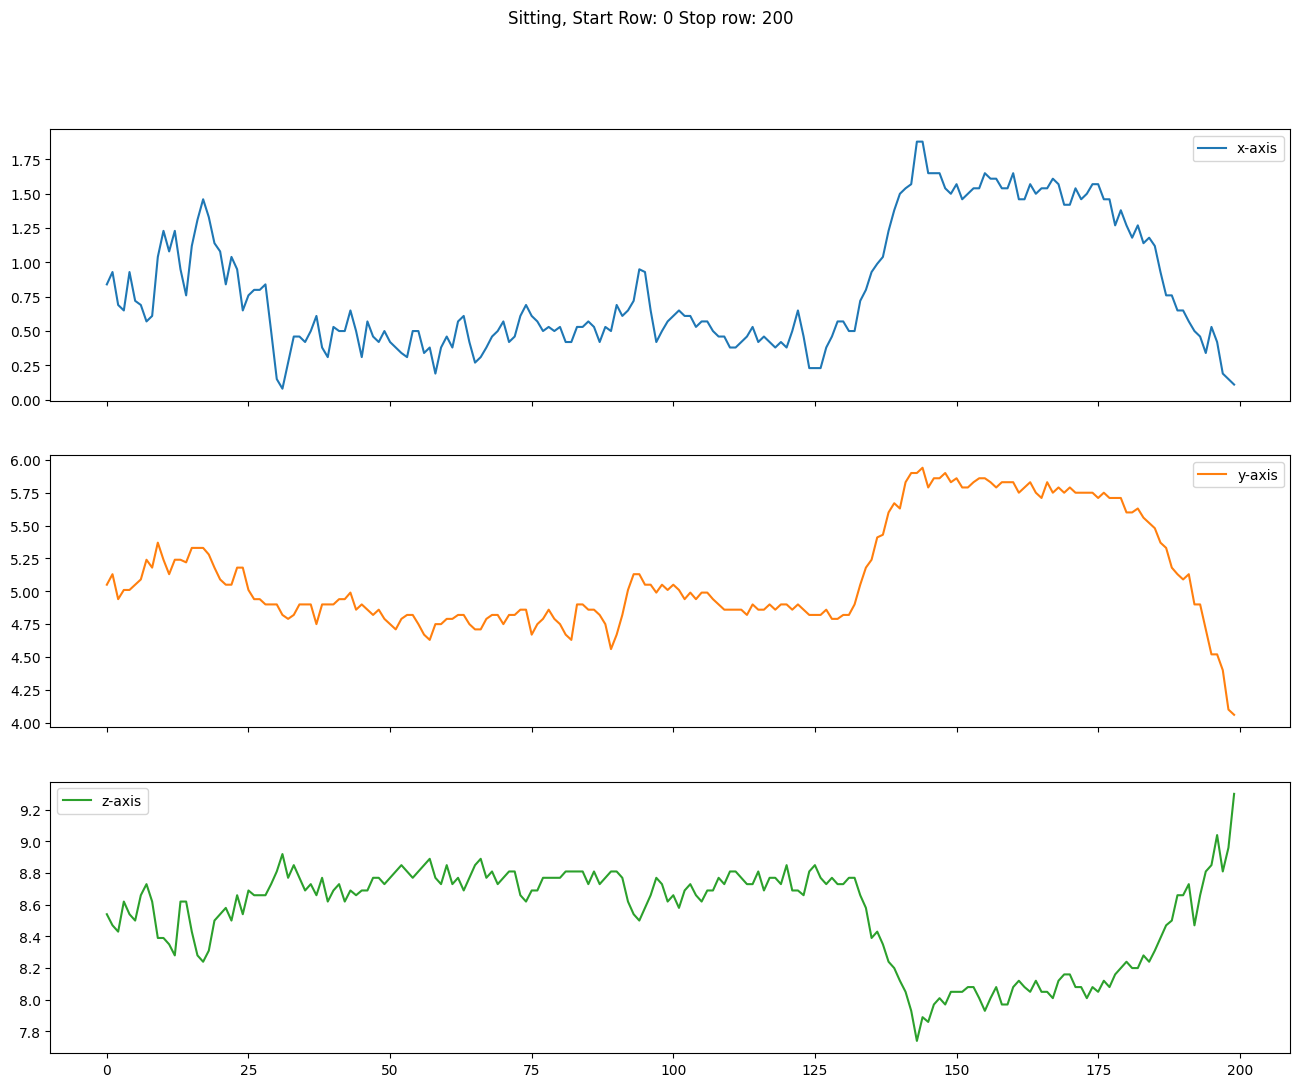

In [ ]:
path = df_paths[0]
activity, filename = path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

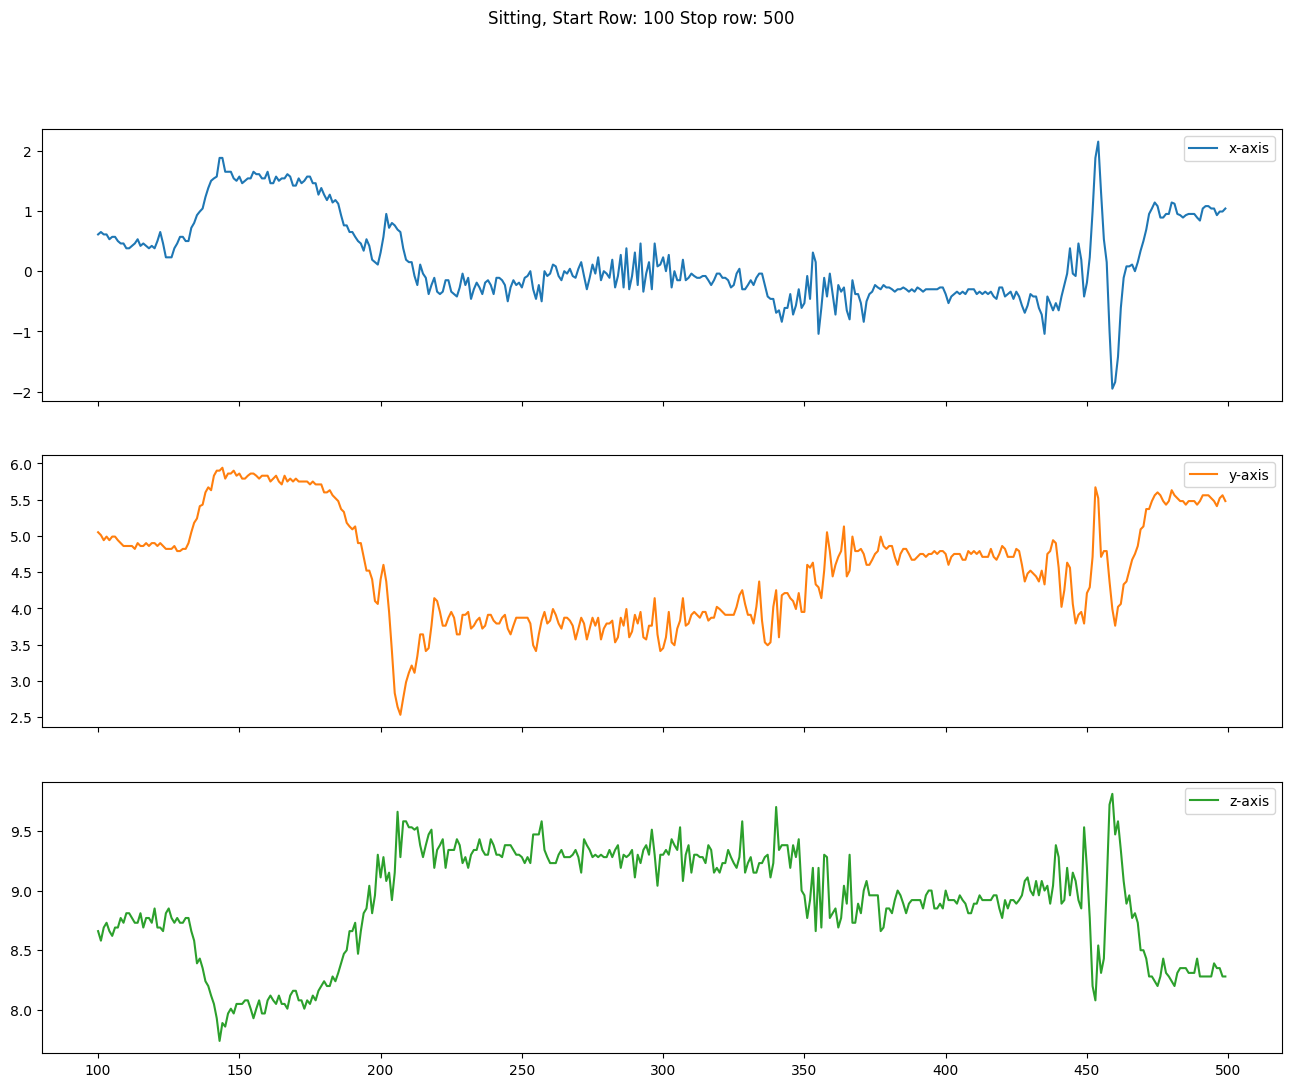

In [ ]:
plot_activity(activity,df,100,500)

# Training, Validation Data

We'll use 80% of the measurements for training and validation.

In [ ]:
from sklearn.model_selection import train_test_split

dataset_paths = {'train': [], 'val': []}

for activity_dir in glob(osp.join(train_dir, '*')):
    paths = glob(osp.join(activity_dir, '*.csv'))
    train_paths, val_paths = train_test_split(paths,test_size= (1-split_train ),random_state=42)
    dataset_paths['train'].extend(train_paths)
    dataset_paths['val'].extend(val_paths)

In [ ]:
len(dataset_paths['train']), len(dataset_paths['val'])

(111, 32)

# Load Dataset

In [ ]:
def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

**Load and preprocess data**

In [ ]:
from sklearn.preprocessing import StandardScaler

dataset_blocks = {'train': {'block': [], 'label': []},
                  'val': {'block': [], 'label': []}}

for dataset in ['train', 'val']:
    paths = dataset_paths[dataset]

    for path in paths:
        activity = path.split(os.sep)[-2]
        df = pd.read_csv(path)

        # Preprocessing
        mms = StandardScaler()
        for feature in list(df.columns):
            df[feature] = mms.fit_transform(df[[feature]])

        samples = frame(df.loc[:, ].values, frame_len, hop_len)
        labels = np.full(samples.shape[0], activity)

        dataset_blocks[dataset]['block'].extend(samples)
        dataset_blocks[dataset]['label'].extend(labels)

    dataset_blocks[dataset]['block'] = np.array(dataset_blocks[dataset]['block'])
    dataset_blocks[dataset]['label'] = np.array(dataset_blocks[dataset]['label'])

In [ ]:
dataset_blocks['train']['block'].shape, dataset_blocks['val']['block'].shape

((12919, 100, 3), (4515, 100, 3))

In [ ]:
dataset_blocks['val']['label'][:10]

array(['Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting', 'Sitting',
       'Sitting', 'Sitting', 'Sitting', 'Sitting'], dtype='<U10')

**One Hot Encode Labels**

In [ ]:
LABELS = os_sorted([osp.split(path)[-1] for path in glob(osp.join(train_dir, '*'))])
LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [ ]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']
    one_hot_encoded = np.zeros((labels.size, len(LABELS)))

    for i, label in enumerate(LABELS):
        index = np.where(labels == label)[0]
        one_hot_encoded[index, i] = 1

    dataset_blocks[dataset]['label'] = one_hot_encoded

In [ ]:
dataset_blocks['val']['label'][:10]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

**Visualize**

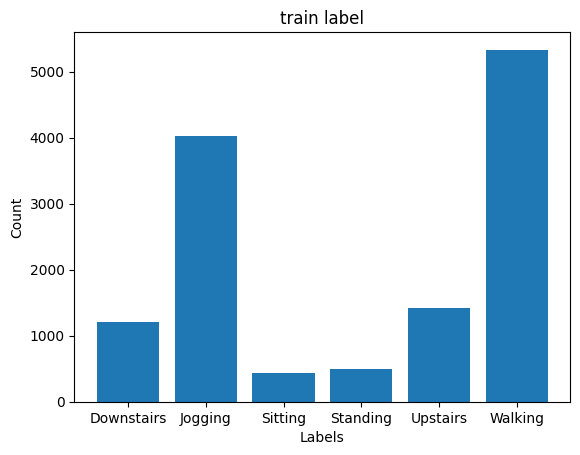

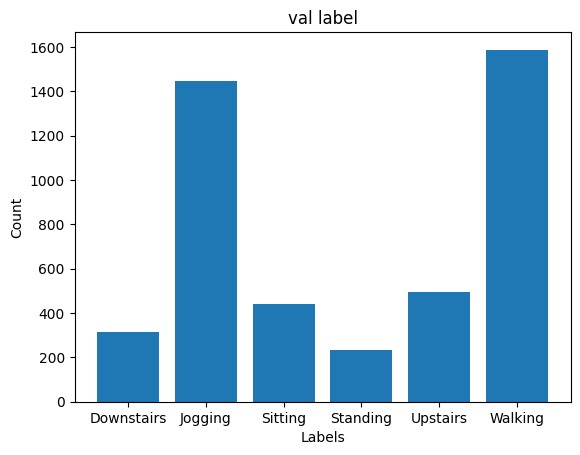

In [ ]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']

    labels_sum = labels.sum(axis=0)

    # Plotting
    plt.bar(LABELS, labels_sum)
    plt.title(f'{dataset} label')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# Model

In [ ]:
# Get the input shape -> (samples, time steps, features)
X_train = dataset_blocks['train']['block']
Y_train = dataset_blocks['train']['label']

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
print('n_timesteps: {}, n_features: {}, n_outputs: {}'.format(n_timesteps,n_features,n_outputs))

n_timesteps: 100, n_features: 3, n_outputs: 6


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Input, Dense, Dropout, Flatten,GlobalMaxPooling1D
model = Sequential()
model.add(Input(shape=(n_timesteps,n_features)))
model.add(Conv1D(16, 8, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 93, 16)            400       
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 46, 16)            0         
 ng1D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 736)               0         
                                                                 
 dense_11 (Dense)            (None, 6)                 4422      
                                                                 
Total params: 4822 (18.84 KB)
Trainable params: 4822 (18.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Dense, Dropout
from keras.regularizers import l2

# Define model architecture
model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))
model.add(Conv1D(32, 8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(64, 4, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, 2, activation='relu', kernel_regularizer=l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


**Training**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['val_loss'])

In [ ]:
# Parameter for models
epochs = 100
batch_size = 32

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [early_stopping, reduce_lr]

In [ ]:
history = model.fit(
    dataset_blocks['train']['block'],
    dataset_blocks['train']['label'],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dataset_blocks['val']['block'], dataset_blocks['val']['label']),
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/100


TypeError: 'str' object is not callable

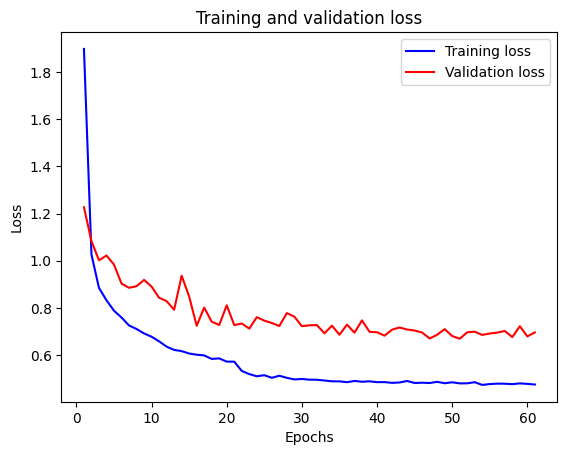

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Validation**

In [ ]:
# evaluate model
loss, accuracy = model.evaluate(dataset_blocks['val']['block'],
                                dataset_blocks['val']['label'], batch_size=batch_size, verbose=0)
print(f'Loss : {loss}')
print(f'Accuracy: {accuracy}')

Loss : 0.6696231365203857
Accuracy: 0.8436323404312134


# Submission

In [ ]:
from sklearn.preprocessing import StandardScaler

answer_list = []

for filename in tqdm(glob(test_dir + '/*.csv')):

    # Read test csv file
    df = pd.read_csv(filename)

    # Preprocessing
    mms = StandardScaler()
    for feature in list(df.columns):
        df[feature] = mms.fit_transform(df[[feature]])

    samples = df.loc[:, ].values

    # Predict
    y_pred_prob = model.predict(np.array(samples).reshape(-1,frame_len,n_features), verbose = 0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    class_names = LABELS[y_pred[0]]

    value = (filename.split('/')[-1], class_names)
    answer_list.append(value)

In [ ]:
import pandas as pd
column_name = ['id','class']
xml_df = pd.DataFrame(answer_list, columns=column_name)
xml_df.to_csv('/kaggle/working/submission_cnn.csv', index=None)